In [ ]:
!pip uninstall -y torch torchvision torchaudio diffusers transformers accelerate xformers bitsandbytes peft datasets huggingface_hub safetensors

!pip install diffusers==0.30.0 transformers accelerate safetensors torchvision torch --upgrade
!pip install -q diffusers==0.30.0 transformers accelerate safetensors bitsandbytes datasets xformers peft
!pip -q install huggingface_hub datasets

!pip install git+https://github.com/openai/CLIP.git


# !pip install torch==2.6.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade
# !pip install diffusers==0.30.0 transformers accelerate safetensors xformers==0.0.27.post2 bitsandbytes==0.43.3
# !pip install huggingface_hub datasets peft


Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
Found existing installation: transformers 4.57.2
Uninstalling transformers-4.57.2:
  Successfully uninstalled transformers-4.57.2
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eopwuw3z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eopwuw3z
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=52e21b005389e554090c7a0b147a633ebf6eacc4e05873e76b5e675c76148e09
  Stored in directory: /tmp/pip-ephem-wheel-cache-68w87jpc/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import diffusers
import numpy as np
import random

import torch
from huggingface_hub import snapshot_download
from datasets import load_dataset, Image, Value, Features
import os



#smaller dataset
# repo_dir = snapshot_download("inmortalkaktus/pokemon-pixel-art", repo_type="dataset")
# pq = os.path.join(repo_dir, "data", "train-00000-of-00001.parquet")
# features = Features({"image": Image(), "text": Value("string")})
# ds = load_dataset("parquet", data_files=pq, features=features)["train"]

#larger dataset
repo_dir = snapshot_download("ffurfaro/PixelBytes-PokemonAll", repo_type="dataset")
pq = os.path.join(repo_dir, "data", "train-00000-of-00001.parquet")
ds = load_dataset("parquet", data_files=pq)["train"]
ds = ds.remove_columns([c for c in ds.column_names if c not in ["image", "text"]])

print(ds.column_names, len(ds))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

['image', 'text'] 533


In [ ]:
def seed_everything(seed=2000):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2000)

In [ ]:
def load_model():

  MODEL_ID = "OFA-Sys/small-stable-diffusion-v0"
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # load the pipeline (FP16 if GPU supports it)
  pipe = diffusers.StableDiffusionPipeline.from_pretrained(MODEL_ID, torch_dtype=torch.float16 if device=="cuda" else torch.float32)
  pipe = pipe.to(device)
  # pipe.enable_xformers_memory_efficient_attention() if hasattr(pipe, "enable_xformers_memory_efficient_attention") else None

  try:
      pipe.enable_xformers_memory_efficient_attention()
  except Exception as e:
      print("⚠️ Skipping xformers:", e)

  print("Loaded model:", MODEL_ID, "on", device)


  return pipe, device

pipe, device = load_model()

model_index.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
save_dir = "/content/pokemon/train"
os.makedirs(save_dir, exist_ok=True)

for i, sample in enumerate(ds):
    # Save image
    img = sample["image"]      # PIL.Image
    img.save(f"{save_dir}/{i:04d}.png")

    # Save caption text
    caption = sample["text"]
    with open(f"{save_dir}/{i:04d}.txt", "w") as f:
        f.write(caption)

print("Done! Saved", len(ds), "images + captions to:", save_dir)



In [ ]:
# --- ADD LoRA ---

from peft import LoraConfig, get_peft_model
import torch.nn as nn


def lora(pipe, device, RANK=4):

  RANK = 4

  unet = pipe.unet

  lora_config = LoraConfig(
      r=RANK,
      lora_alpha=16,
      target_modules=["to_q", "to_k", "to_v", "to_out.0", "proj_out"],
      lora_dropout=0.05,
      bias="none"
  )

  unet = get_peft_model(unet, lora_config)
  unet.to(device)
  pipe.unet = unet

  trainable = [p for p in unet.parameters() if p.requires_grad]
  print("✅ LoRA attached. Trainable params:", sum(p.numel() for p in trainable))

  return unet, trainable



def no_finetune(pipe, device):
    """
    Disables all fine-tuning by:
      - not attaching LoRA
      - freezing every parameter of the UNet
    """

    unet = pipe.unet

    # Freeze all parameters
    for p in unet.parameters():
        p.requires_grad = False

    unet.to(device)
    pipe.unet = unet

    trainable = [p for p in unet.parameters() if p.requires_grad]
    print("🚫 No fine-tune mode active. Trainable params:",
          sum(p.numel() for p in trainable))

    return unet, trainable



# unet, trainable = lora(pipe, device)
unet, trainable = no_finetune(pipe, device)

Plot Losses

In [ ]:
import matplotlib.pyplot as plt
import torch
import clip

# --------------------------------------
# Storage for logs
# --------------------------------------
train_losses = []
val_losses = []
clip_scores = []

# --------------------------------------
# CLIP model for similarity
# --------------------------------------
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

from torchvision.transforms.functional import to_pil_image

def compute_clip_score(imgs, texts):
    """
    imgs: tensor batch in [-1,1]
    texts: list of captions
    """

    # ---- 1. Truncate long captions for CLIP (max context length 77 tokens) ----
    # Hard truncate to ~200 chars (safe for CLIP)
    texts = [t[:200] for t in texts]

    # ---- 2. Convert tensors → PIL ----
    pil_imgs = []
    for img in imgs:
        img = (img * 0.5 + 0.5).clamp(0,1)
        pil_imgs.append(to_pil_image(img.cpu()))

    # ---- 3. Preprocess for CLIP ----
    imgs_pre = torch.stack([clip_preprocess(p) for p in pil_imgs]).to(device)

    # truncate=True prevents CLIP errors
    text_tokens = clip.tokenize(texts, truncate=True).to(device)

    with torch.no_grad():
        img_feat = clip_model.encode_image(imgs_pre)
        txt_feat = clip_model.encode_text(text_tokens)

    img_feat /= img_feat.norm(dim=-1, keepdim=True)
    txt_feat /= txt_feat.norm(dim=-1, keepdim=True)

    similarity = (img_feat * txt_feat).sum(dim=-1)
    return similarity.mean().item()


# --------------------------------------
# Validation step
# --------------------------------------
def validate(val_loader, vae, text_encoder, tokenizer, noise_scheduler):
    unet.eval()
    total_loss = 0
    count = 0

    with torch.no_grad():
        for imgs, captions in val_loader:
            imgs = imgs.to(device, dtype=torch.float16 if device=="cuda" else torch.float32)

            latents = vae.encode(imgs).latent_dist.sample() * 0.18215

            # Add noise
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=device
            ).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Text encode
            text_inputs = tokenizer(
                captions, padding="max_length", truncation=True,
                max_length=tokenizer.model_max_length,
                return_tensors="pt"
            ).to(device)

            enc = text_encoder(text_inputs.input_ids)[0]

            # Predict noise
            pred = unet(noisy_latents, timesteps, encoder_hidden_states=enc).sample
            loss = ((pred - noise) ** 2).mean()

            total_loss += loss.item()
            count += 1

    unet.train()
    return total_loss / count


# --------------------------------------
# Plotting function
# --------------------------------------
def plot_losses(train_losses, val_losses, learning_rate, weight_decay):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Train vs Validation Loss (lr={learning_rate}, wd={weight_decay})")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_clip_scores(clip_scores, learning_rate, weight_decay):
    epochs = range(1, len(clip_scores) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, clip_scores, label="CLIP Score")
    plt.xlabel("Epoch")
    plt.ylabel("CLIP Score")
    plt.title(f"CLIP Score per Epoch (lr={learning_rate}, wd={weight_decay})")
    plt.grid(True)
    plt.show()


def plot_losses_fixed_axis(train_losses, val_losses):
    import matplotlib.pyplot as plt

    epochs = list(range(len(train_losses)))

    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")

    plt.ylim(0.10, 0.50)          # <-- Static y-axis
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import torch
from torch.optim import AdamW
import os

class SimpleDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted([f for f in os.listdir(folder) if f.endswith(".png")])
        self.folder = folder
        self.transform = transforms.Compose([
            transforms.Resize((512,512), interpolation=Image.NEAREST),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img_path = os.path.join(self.folder, self.files[idx])
        txt_path = img_path.replace(".png", ".txt")

        img = Image.open(img_path).convert("RGB")
        with open(txt_path, "r") as f:
            caption = f.read().strip()
        return self.transform(img), caption



def train(learning_rate, weight_decay, num_epochs=10, batch_size=2, lora=1):

    pipe, device = load_model()

    # ------------------------------------
    #   LoRA or No-Finetune setup
    # ------------------------------------
    if lora == 1:
        unet, trainable = attach_lora(pipe, device)
        print("🔧 LoRA training enabled.")
    else:
        unet, trainable = no_finetune(pipe, device)
        print("🚫 No fine-tuning mode enabled.")

    # Optimizer (only if trainable params exist)
    if len(trainable) == 0:
        optimizer = None
        print("⚠️ No trainable params — optimizer disabled.")
    else:
        optimizer = AdamW(trainable, lr=learning_rate, weight_decay=weight_decay)
        print(f"🧮 Optimizer initialized with {sum(p.numel() for p in trainable)} params.")

    # ------------------------------------
    #   Dataset and loaders
    # ------------------------------------
    dataset = SimpleDataset(save_dir)
    val_size = max(1, len(dataset) // 10)

    train_subset, val_subset = torch.utils.data.random_split(
        dataset, [len(dataset)-val_size, val_size]
    )

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

    vae            = pipe.vae
    noise_scheduler = pipe.scheduler
    tokenizer       = pipe.tokenizer
    text_encoder    = pipe.text_encoder

    unet.train()

    # Reset logs
    train_losses.clear()
    val_losses.clear()
    clip_scores.clear()

    # -------------------------------------------------
    #                EPOCH 0 EVALUATION
    # -------------------------------------------------
    print("\n📊 Running Epoch 0 (initial evaluation)...")

    unet.eval()

    initial_train_loss = validate(train_loader, vae, text_encoder, tokenizer, noise_scheduler)
    initial_val_loss   = validate(val_loader,   vae, text_encoder, tokenizer, noise_scheduler)

    train_losses.append(initial_train_loss)
    val_losses.append(initial_val_loss)

    print(f"Epoch 0: train={initial_train_loss:.4f}, val={initial_val_loss:.4f}")

    unet.train()

    # -------------------------------------------------
    #                TRAINING LOOP
    # -------------------------------------------------
    for epoch in range(1, num_epochs + 1):

        epoch_loss = 0.0
        batches = 0

        for imgs, captions in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):

            imgs = imgs.to(device, dtype=torch.float16 if device=="cuda" else torch.float32)

            # ----- VAE encode -----
            with torch.no_grad():
                latents = vae.encode(imgs).latent_dist.sample() * 0.18215

            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=device
            ).long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # ----- Text encode -----
            text_inputs = tokenizer(
                captions,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            ).to(device)

            with torch.no_grad():
                encoder_hidden_states = text_encoder(text_inputs.input_ids)[0]

            # ----- UNet forward -----
            pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=encoder_hidden_states
            ).sample

            loss = ((pred - noise) ** 2).mean()

            # ----- Backprop only if trainable params exist -----
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            batches += 1

        avg_train_loss = epoch_loss / batches
        train_losses.append(avg_train_loss)

        # ------------------------
        #       VALIDATION
        # ------------------------
        val_loss = validate(val_loader, vae, text_encoder, tokenizer, noise_scheduler)
        val_losses.append(val_loss)

        # ------------------------
        #       CLIP SCORE
        # ------------------------
        clip_score = compute_clip_score(*next(iter(val_loader)))
        clip_scores.append(clip_score)

        print(f"Epoch {epoch}: train={avg_train_loss:.4f}, val={val_loss:.4f}, clip={clip_score:.4f}")

        if lora == 1:
            unet.save_pretrained(f"/content/adamw/lora_epoch_{epoch}")

    print("🎉 Training complete.")

    # ------------------------------------
    #     PLOT WITH FIXED Y AXIS
    # ------------------------------------
    if lora == 0:
        plot_losses_fixed_axis(train_losses, val_losses)
    else:
        plot_losses(train_losses, val_losses, learning_rate, weight_decay)


    print("\n===== FINAL METRICS =====")
    print(f"Training Loss:    {train_losses[-1]:.4f}")
    print(f"Validation Loss:  {val_losses[-1]:.4f}")
    print(f"CLIP Score:       {clip_scores[-1]:.4f}")

    return {
        'train_loss': train_losses[-1],
        'val_loss':   val_losses[-1],
        'clip_score': clip_scores[-1],
    }


RUNNINNG FOR:
Learning Rate: 0.0001
Weight Decay: 0.01


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--OFA-Sys--small-stable-diffusion-v0/snapshots/38e10e5e71e8fbf717a47a81e7543cd01c1a8140/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'predict_epsilon': True} were passed to DPMSolverMultis

⚠️ Skipping xformers: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
Loaded model: OFA-Sys/small-stable-diffusion-v0 on cuda
🚫 No fine-tune mode active. Trainable params: 0
🚫 No fine-tuning mode enabled.
⚠️ No trainable params — optimizer disabled.

📊 Running Epoch 0 (initial evaluation)...
Epoch 0: train=0.3515, val=0.3570


Epoch 1/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1: train=0.3440, val=0.3070, clip=0.3291


Epoch 2/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2: train=0.3385, val=0.3717, clip=0.3291


Epoch 3/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3: train=0.3337, val=0.4280, clip=0.3291


Epoch 4/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4: train=0.3539, val=0.3362, clip=0.3291


Epoch 5/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5: train=0.3535, val=0.3833, clip=0.3291


Epoch 6/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6: train=0.3091, val=0.2842, clip=0.3291


Epoch 7/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7: train=0.3186, val=0.2727, clip=0.3291


Epoch 8/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8: train=0.3490, val=0.4019, clip=0.3291


Epoch 9/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9: train=0.3569, val=0.4063, clip=0.3291


Epoch 10/10:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10: train=0.3145, val=0.3020, clip=0.3291
🎉 Training complete.


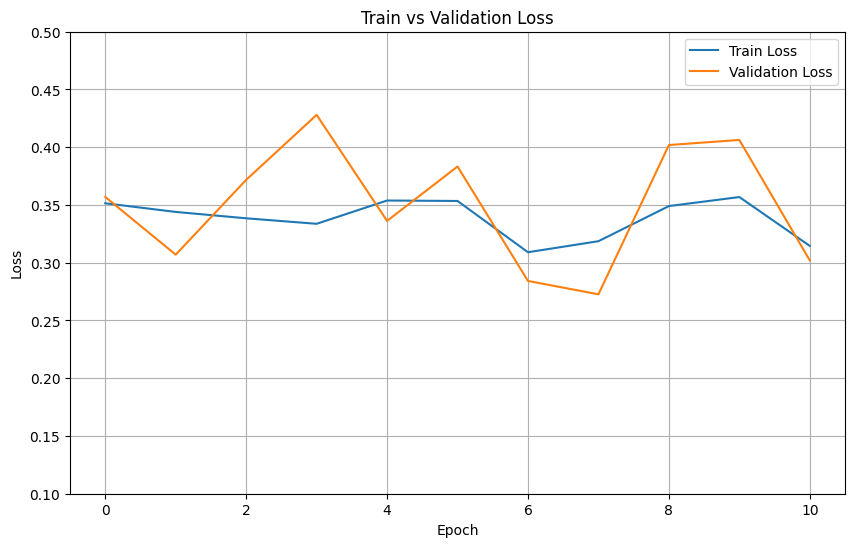


===== FINAL METRICS =====
Training Loss:    0.3145
Validation Loss:  0.3020
CLIP Score:       0.3291
--------------------------------------------------


In [ ]:

lrs = [1e-3, 1e-3, 1e-4, 1e-5, 1e-6]
wds = [1e-1, 1e-2, 1e-3, 1e-4]
INDIVIDUAL_RUN = True
EPOCHS = 10


if INDIVIDUAL_RUN:
  lrs = [1e-4]
  wds = [1e-2]

result = {}
#hyperparameter tuning
for lr in lrs:
  for wd in wds:
    print(f"RUNNINNG FOR:")
    print(f"Learning Rate: {lr}")
    print(f"Weight Decay: {wd}")
    result[(lr, wd)] = train(
        learning_rate=lr,
        weight_decay=wd,
        num_epochs=EPOCHS,
        batch_size=4,
        lora=0
    )
    print("-"*50)

In [ ]:
pipe.safety_checker = lambda images, clip_input: (images, [False] * images.shape[0])

prompt = "a cute pixel art dragon pokemon creature"
image = pipe(prompt, num_inference_steps=20).images[0]
image.save("/content/adamw/test_output.png")
print("✅ Saved:", "/content/adamw/test_output.png")


In [ ]:
result

In [ ]:
best_combo = min(result, key=lambda k: result[k]['val_loss'])
best_combo

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

lrs = sorted({key[0] for key in result})
wds = sorted({key[1] for key in result})

# Convert to log10 scale
log_lrs = np.log10(lrs)
log_wds = np.log10(wds)

# Create meshgrid
LOG_LR, LOG_WD = np.meshgrid(log_lrs, log_wds)

# Fill val_loss matrix
VAL = np.zeros_like(LOG_LR)
for i, wd in enumerate(wds):
    for j, lr in enumerate(lrs):
        VAL[i, j] = result[(lr, wd)]['val_loss']

# Use real val_loss values directly
Z = VAL

# vmin/vmax should match Z since that's what controls color
vmin = Z.min()
vmax = Z.max()

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    LOG_LR, LOG_WD, Z,
    cmap='viridis',
    edgecolor='k',
    linewidth=0.5,
    alpha=0.95,
    vmin=vmin,
    vmax=vmax
)

ax.invert_zaxis()

# Axis labels
ax.set_xlabel("log10(Learning Rate)", fontsize=12)
ax.set_ylabel("log10(Weight Decay)", fontsize=12)
ax.set_zlabel("Validation Loss", fontsize=12)
ax.set_title("3D Surface of Validation Loss (Log-Scaled LR & WD)", fontsize=15)

# Pretty scientific-notation ticks
ax.set_xticks(log_lrs)
ax.set_xticklabels([f"{lr:.0e}" for lr in lrs])

ax.set_yticks(log_wds)
ax.set_yticklabels([f"{wd:.0e}" for wd in wds])

# Add correct colorbar
fig.colorbar(surf, shrink=0.6, aspect=12)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_multiple(learning_rate, weight_decay, num_epochs=10, batch_size=2, lora=1, runs=5):
    """
    Runs your training function N times and computes error bars.
    """

    all_train = []
    all_val = []

    for r in range(runs):
        print(f"\n============================")
        print(f"🔥 RUN {r+1}/{runs}")
        print(f"============================")

        out = train(
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_epochs=num_epochs,
            batch_size=batch_size,
            lora=lora
        )

        # Copy the global logs after this run
        all_train.append(train_losses.copy())
        all_val.append(val_losses.copy())

    # Convert to NumPy arrays → shape (runs, epochs+1)
    all_train = np.array(all_train)
    all_val = np.array(all_val)

    # Compute mean/stdev along axis=0
    train_mean = all_train.mean(axis=0)
    train_std  = all_train.std(axis=0)

    val_mean = all_val.mean(axis=0)
    val_std  = all_val.std(axis=0)

    # -----------------------------
    #    Plot with error bars
    # -----------------------------
    epochs = np.arange(len(train_mean))

    plt.figure(figsize=(10,6))

    plt.errorbar(
        epochs, train_mean, yerr=train_std,
        fmt='-o', capsize=4, label="Train Loss (mean ± std)"
    )
    plt.errorbar(
        epochs, val_mean, yerr=val_std,
        fmt='-o', capsize=4, label="Val Loss (mean ± std)"
    )

    plt.ylim(0.10, 0.50)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss w/ Error Bars over {runs} Runs")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    #  Print epoch-by-epoch summary
    # -----------------------------------
    print("\n===== MEAN ± STD PER EPOCH =====")
    for e in range(len(train_mean)):
        print(f"Epoch {e}: "
              f"Train {train_mean[e]:.4f} ± {train_std[e]:.4f} | "
              f"Val {val_mean[e]:.4f} ± {val_std[e]:.4f}")

    return {
        "train_mean": train_mean,
        "train_std":  train_std,
        "val_mean":   val_mean,
        "val_std":    val_std,
        "raw_train":  all_train,
        "raw_val":    all_val,
    }


In [ ]:
results = run_multiple(
    learning_rate=1e-4,
    weight_decay=0.01,
    num_epochs=10,
    batch_size=2,
    lora=1,
    runs=5
)
